##### Step 1. Import necessary tools and libraries

In [1]:
import pandas as pd
import numpy as np
import nltk
import re
import string
import contractions
import collections
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.dummy import DummyRegressor
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
import seaborn as sns
from lime.lime_text import LimeTextExplainer
import shap
import eli5
from eli5.lime import TextExplainer
import timeit

In [2]:
#!pip freeze > requirements.txt
#conda env export > environment.yml

##### Step 2. Load dataset for supervised learning

In [3]:
df = pd.read_csv('train_hurricane_with_name.csv')
df = df.drop_duplicates(subset=['text', 'class_label'], keep=False)  # drop duplicates in dataset
df['date'] =  pd.to_datetime(df['created_at'])
df.head(3)

Unnamed: 0            tweet_id  \
0           0  783409770493571076   
1           1  784696725285908481   
2           2  783549594416377856   

                                                text  \
0  Horrifying. My heart breaks for Haiti. Thinkin...   
1  #BreakingNews Hurricane Matthew kills over 800...   
2  Southern Haiti effectively cut off after the b...   

                  class_label hurricane  fatalities  damage(billion USD)  \
0        sympathy_and_support   matthew         603                16.47   
1      injured_or_dead_people   matthew         603                16.47   
2  other_relevant_information   matthew         603                16.47   

   Unnamed: 0.1   author_id                 created_at  ...  \
0             0    30316960  2016-10-04 20:53:38+00:00  ...   
1             1  2182497116  2016-10-08 10:07:32+00:00  ...   
2             2    97883743  2016-10-05 06:09:15+00:00  ...   

   in_reply_to_user_id attachments lang possibly_sensitive  \
0                  NaN         NaN   en                NaN   
1                  NaN         NaN   en                NaN   
2                  NaN         NaN   en                NaN   

                                      public_metrics  \
0  {'retweet_count': 0, 'reply_count': 0, 'like_c...   
1  {'retweet_count': 0, 'reply_count': 0, 'like_c...   
2  {'retweet_count': 1, 'reply_count': 0, 'like_c...   

                                   referenced_tweets reply_settings  \
0  [<ReferencedTweet id=783408890222444548 type=q...       everyone   
1                                                NaN       everyone   
2  [<ReferencedTweet id=783548240650244097 type=q...       everyone   

                      source                      date  norm_date  
0                  TweetDeck 2016-10-04 20:53:38+00:00   2.052895  
1                    dlvr.it 2016-10-08 10:07:32+00:00  99.741796  
2  Twitter for Windows Phone 2016-10-05 06:09:15+00:00  12.666631  

[3 rows x 24 columns]

##### Step 3. Simple EDA

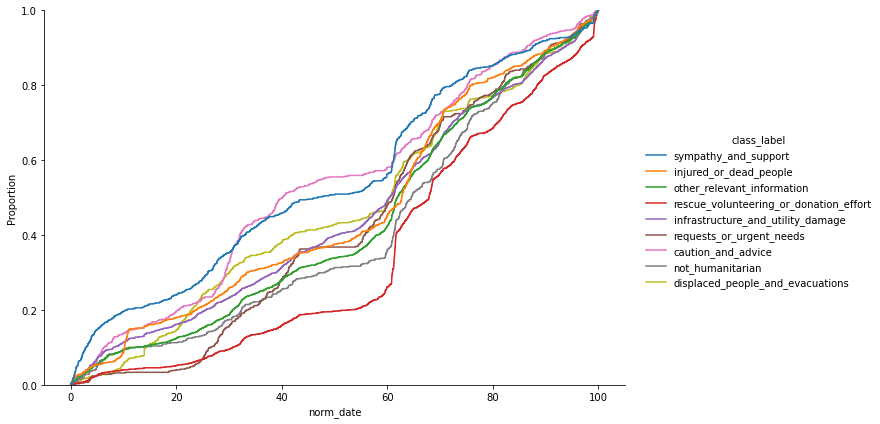

In [4]:
# proportion of labels overtime per hurricane
sns.displot(
    df,
    x="norm_date", hue="class_label", stat='proportion',
    kind="ecdf", height=6, aspect=1.5, linewidth=1.5
)

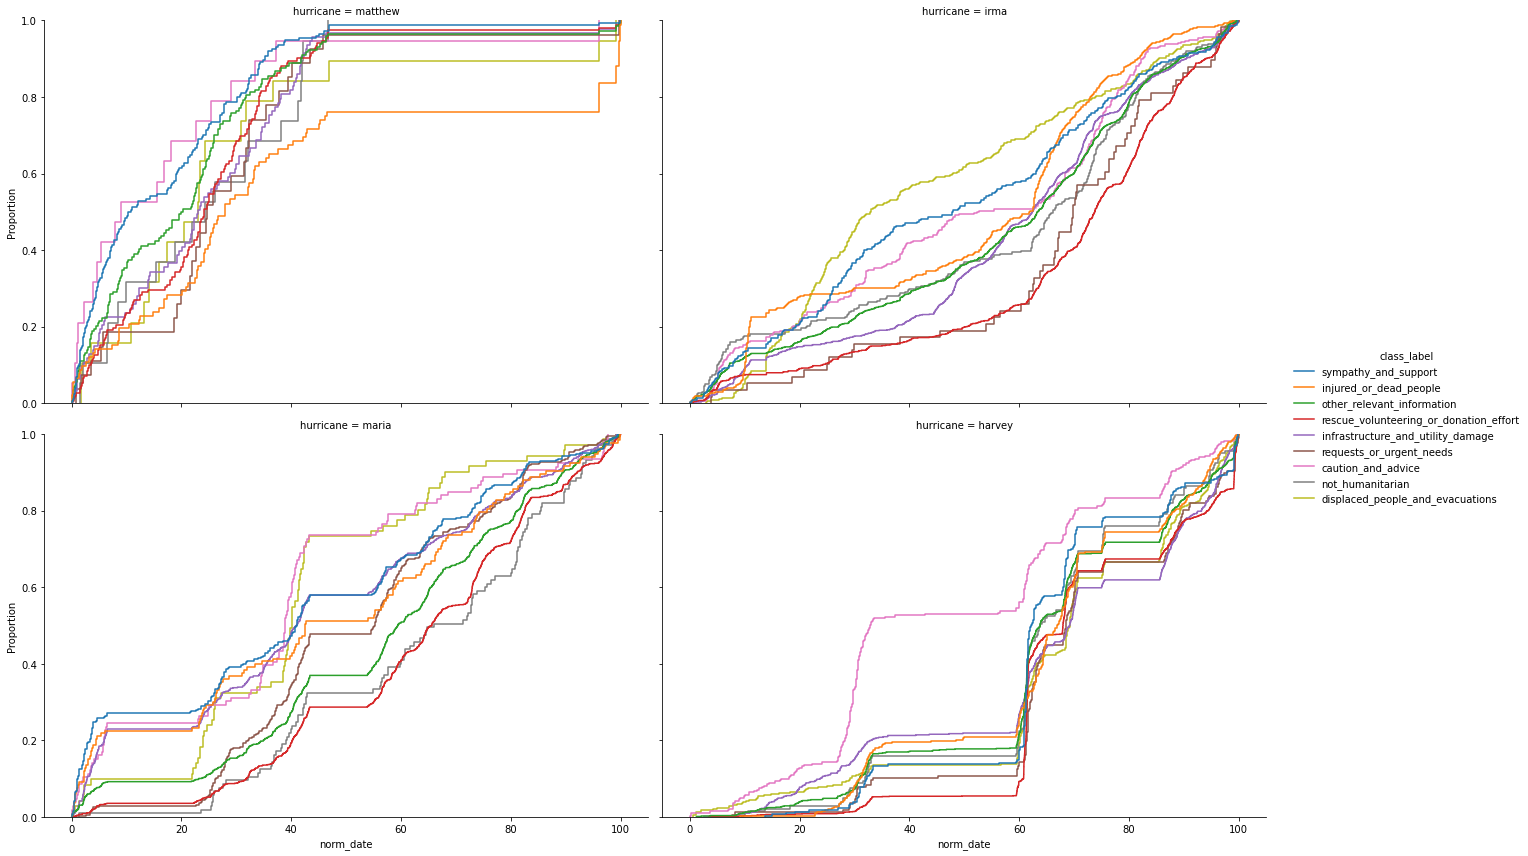

In [5]:
sns.displot(
    df,
    x="norm_date", col="hurricane", hue="class_label",
    kind="ecdf", height=6, aspect=1.5, linewidth=1.5, col_wrap=2
)

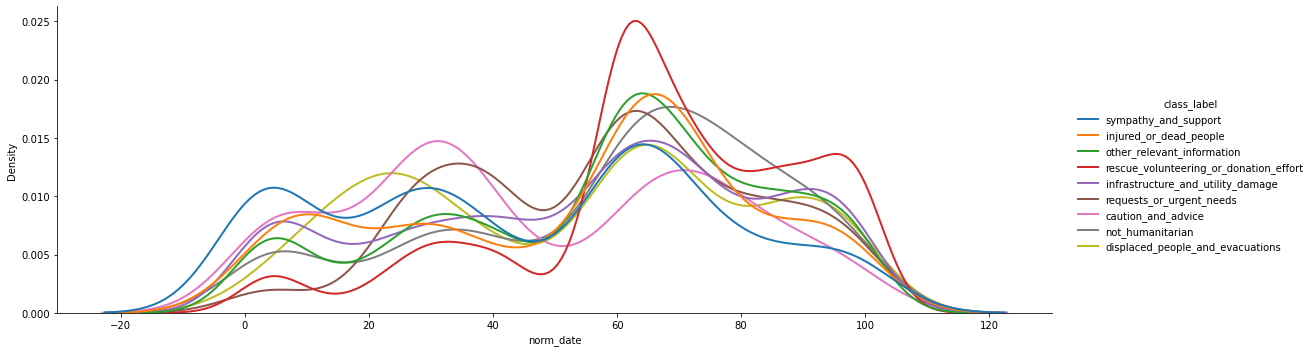

In [6]:
# density of labels overtime per hurricane
g = sns.displot(
    df,
    x="norm_date", hue="class_label", common_norm=False, 
    kind="kde", height=5, aspect=3, linewidth=2
)

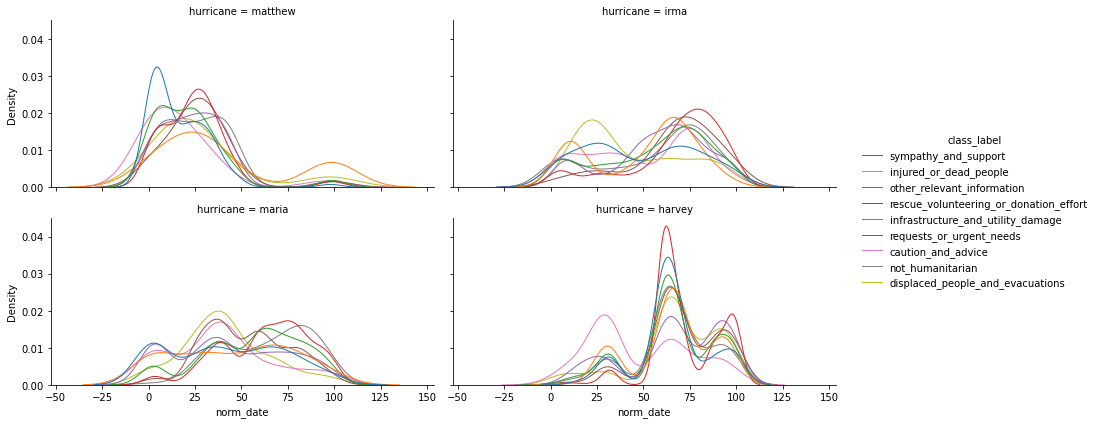

In [7]:
g = sns.displot(
    df,
    x="norm_date", col="hurricane", hue="class_label", common_norm=False,
    kind="kde", height=3, aspect=2, linewidth=1, col_wrap=2
)

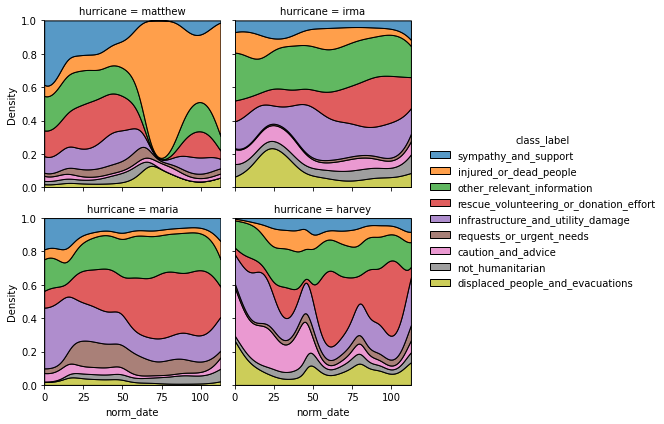

In [8]:
sns.displot(
    data=df,
    x="norm_date", col='hurricane', hue="class_label",
    kind="kde", height=3,
    multiple="fill", clip=(0, None), col_wrap=2
)

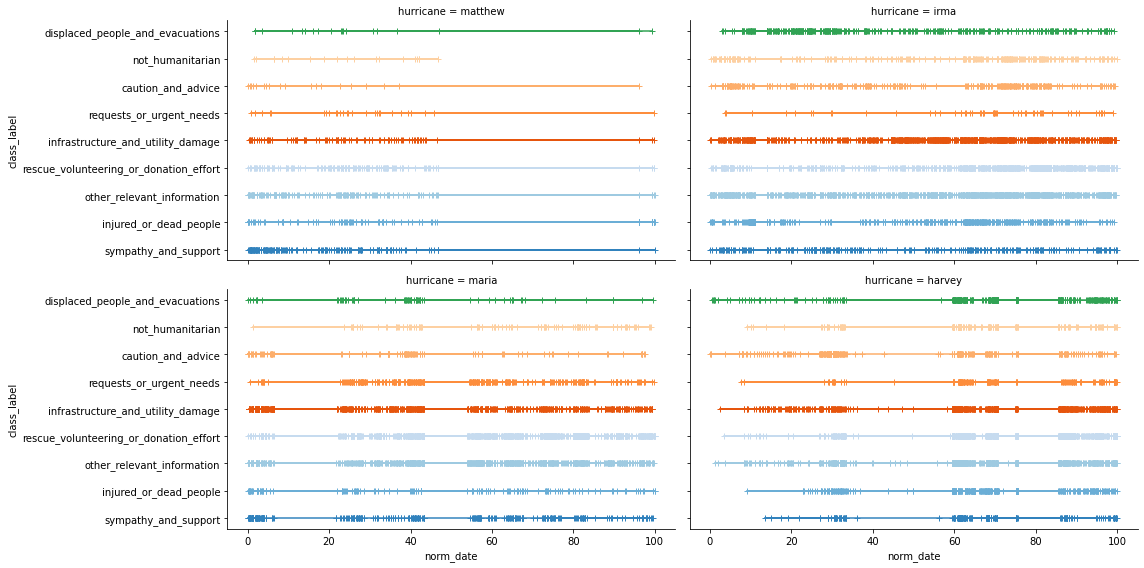

In [11]:
# occurunce spot of labels overtime per hurricane
grid = sns.FacetGrid(df, col="hurricane", hue="class_label", palette="tab20c",
                     col_wrap=2, height=4, aspect=2)
grid.map(plt.plot, "norm_date", "class_label", marker="+")

<AxesSubplot:xlabel='norm_date', ylabel='class_label'>

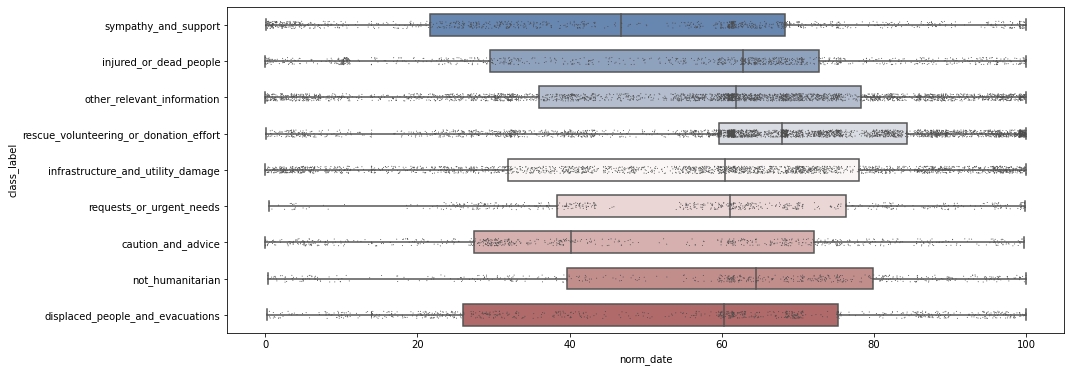

In [12]:
# label boxplot overtime, all hurricanes
f, ax = plt.subplots(figsize=(15, 6))
sns.boxplot(x="norm_date", y="class_label", data=df,
            whis=[0, 100], width=.6, palette="vlag")
sns.stripplot(x="norm_date", y="class_label", data=df,
              size=1, color=".3", linewidth=0)


##### Step. 4. Preprocess text data

In [10]:
# select or combine lemmatization, stemming, stopword removal to compare performance
stop_words = nltk.corpus.stopwords.words('english')

def preprocess_text(text, flg_stemm = True, flg_lemm = True, lst_stopwords=None):
    text_clean = re.sub(r'[^\w\s.,@]', '', str(text).strip())
    lst_text = text_clean.split()
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in lst_stopwords]
    if flg_stemm == True:
        stemm = nltk.stem.porter.PorterStemmer()
        lst_text = [stemm.stem(word) for word in lst_text]
    if flg_lemm == True:
        lem=nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]

    text_clean = ' '.join(filter(None, lst_text))
    text_clean = text_clean.replace(" ,",",").replace(' .', '.')
    text_clean = contractions.fix(text_clean)
    return text_clean

df['pre_processed'] = df['text'].apply(lambda x: preprocess_text(x, flg_stemm=True, flg_lemm=True, lst_stopwords=stop_words))
df = df[['pre_processed', 'class_label']]
df.head()

pre_processed  \
0  horrifying. my heart break haiti. think many, ...   
1  breakingnew hurrican matthew kill 800 haiti, g...   
2  southern haiti effect cut bridg link capital, ...   
3  hurrican matthew hit haiti, aim you east coast...   
4  our thought prayer today peopl haiti cuba ever...   

                  class_label  
0        sympathy_and_support  
1      injured_or_dead_people  
2  other_relevant_information  
3  other_relevant_information  
4        sympathy_and_support

##### Step 5. Split dataset and transform to TF-IDF text representation

In [11]:
X_train, X_test, y_train, y_test = train_test_split(df['pre_processed'], df['class_label'], random_state=42, test_size=0.20, shuffle=True)

tfidf_vec = TfidfVectorizer(ngram_range=(1,2), lowercase=True, min_df = 3)
train_vc = tfidf_vec.fit_transform(X_train)
test_vc = tfidf_vec.transform(X_test)

##### Step 6. Check initial performance on default classifiers

The max_iter was reached which means the coef_ did not converge


accuracy precision    recall f1-score
Logistic Regression  0.73494  0.714378  0.672028  0.68359

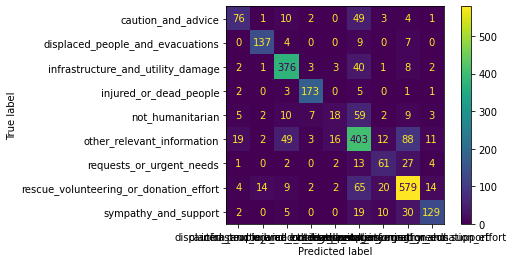

In [39]:
seed = 42
#kfold = model_selection.KFold(n_splits=10, random_state=seed, shuffle=True)
models = {"Logistic Regression": LogisticRegression(),
          "MultinomialNB": MultinomialNB(),
          "RandomForest": RandomForestClassifier(),
          "SVM": SVC(), #boxed out due to computational cost
          "MLP": MLPClassifier()
          }

results_df = pd.DataFrame(columns=['accuracy', 'precision', 'recall', 'f1-score'])
#results_roc = pd.DataFrame(columns=['classifiers', 'fpr', 'tpr', 'auc'])
target_names = list(df['class_label'].unique())


for name, model in models.items():
    
    #kfold = model_selection.KFold(n_splits=10, random_state=seed, shuffle=True)
    fit = model.fit(train_vc, y_train)
    pred = model.predict(test_vc)
    #yproba = model.predict_proba(test_vc)[::, 1]
    #fpr, tpr, _ = metrics.roc_curve(y_test, yproba)
    #auc = metrics.roc_auc_score(y_test, yproba)
    #results_roc = results_roc.append({'classifiers':model.__class__.__name__, 'fpr':fpr, 'tpr':tpr, 'auc':auc}, ignore_index=True)

    report_dict = metrics.classification_report(y_test, pred, target_names=target_names, output_dict=True)
        
    results_df.loc[name, 'accuracy'] = report_dict['accuracy']
    results_df.loc[name, 'precision'] = report_dict['macro avg']['precision']
    results_df.loc[name, 'recall'] = report_dict['macro avg']['recall']
    results_df.loc[name, 'f1-score'] = report_dict['macro avg']['f1-score']

    metrics.plot_confusion_matrix(fit, test_vc, y_test)
results_df

##### Step 7. Perform GridSearchCV to optimize classifiers

In [46]:
#classifier and parameter setting for gridsearch
#five-fold cross validation used
#created each classifier seperately due to computational cost
#boxed out due to computational cost

"""
lr_classifier = LogisticRegression()
nb_classifier = MultinomialNB()
rf_classifier = RandomForestClassifier()
svm_classifier = SVC()
MLPClassifier = MLPClassifier()

lr_parameters = {'C' : [0.005, 0.01, 0.05, 0.1, 1, 10, 100], 'penalty' : ['l2', 'elasticnet'], 'multi_class': ['auto', 'ovr', 'multinomial']}
nb_parameters = {'alpha' : [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100, 1000], 'fit_prior' : ['True', 'False']}
rf_parameters = {'n_estimators' : ['100', '200', '300'], 'max_depth': [3, 5, 10]}
svc_parameters = {'C' : [0.005, 0.01, 0.05, 0.1, 1, 10, 100], 'penalty' : ['l2', 'elasticnet'], 'multi_class': ['rbf', 'ovr', 'multinomial']}
mlp_parameters = {'hidden_layer_sizes' : [10, 50, 100, 200], 'activation' : ['identity', 'logistic', 'tanh', 'relu'], 'alpha' : ['0.0001', '0.001', '0.01', '0.1']}

lr_best = GridSearchCV(lr_classifier, lr_parameters)
lr_best.fit(train_vc, y_train)
lr_best.best_params_
lr_pred = lr_best.predict(test_vc)
metrics.classification_report(y_test, lr_pred, target_names=target_names, output_dict=True)

nb_best = GridSearchCV(nb_classifier, nb_parameters, cv=5)
nb_best.fit(train_vc, y_train)
nb_best.best_params_
nb_pred = nb_best.predict(test_vc)
metrics.classification_report(y_test, nb_pred, target_names=target_names, output_dict=True)

rf_best = GridSearchCV(nb_classifier, nb_parameters, cv=5)
rf_best.fit(train_vc, y_train)
rf_best.best_params_
rf_pred = nb_best.predict(test_vc)
metrics.classification_report(y_test, rf_pred, target_names=target_names, output_dict=True)

svm_best = GridSearchCV(svc_classifier, svc_parameters, cv=5)
svm_best.fit(train_vc, y_train)
svm_best.best_params_
svm_pred = svm_best.predict(test_vc)
metrics.classification_report(y_test, svm_pred, target_names=target_names, output_dict=True)

mlp_best = GridSearchCV(MLPClassifier, mlp_parameters, cv=5)
mlp_best.fit(train_vc, y_train)
mlp_best.best_params_
mlp_pred = mlp_best.predict(test_vc)
metrics.classification_report(y_test, mlp_pred, target_names=target_names, output_dict=True)

tune classifiers based on result of gridsearch
"""


"\nlr_classifier = LogisticRegression()\nnb_classifier = MultinomialNB()\nrf_classifier = RandomForestClassifier()\nsvm_classifier = SVC()\nMLPClassifier = MLPClassifier()\n\nlr_parameters = {'C' : [0.005, 0.01, 0.05, 0.1, 1, 10, 100], 'penalty' : ['l2', 'elasticnet'], 'multi_class': ['auto', 'ovr', 'multinomial']}\nnb_parameters = {'alpha' : [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100, 1000], 'fit_prior' : ['True', 'False']}\nrf_parameters = {'max_depth': [3, 5, 10]}\nsvc_parameters = {'C' : [0.005, 0.01, 0.05, 0.1, 1, 10, 100], 'penalty' : ['l2', 'elasticnet'], 'multi_class': ['rbf', 'ovr', 'multinomial']}\nmlp_parameters = {'hidden_layer_sizes' : [10, 50, 100, 200], 'activation' : ['identity', 'logistic', 'tanh', 'relu'], 'alpha' : ['0.0001', '0.001', '0.01', '0.1']}\n\nlr_best = GridSearchCV(lr_classifier, lr_parameters)\nlr_best.fit(train_vc, y_train)\nlr_best.best_params_\nlr_pred = lr_best.predict(test_vc)\nmetrics.classification_report(y_test, lr_pred, target_names=target_names, o

In [50]:
# test optimized classifiers

models = {"Logistic Regression": LogisticRegression(C=1, multi_class='multinomial', penalty='l1', solver='saga'),
          "MultinomialNB": MultinomialNB(fit_prior=False, alpha=5),
          "RandomForest": RandomForestClassifier(n_estimators=200, max_depth = None),
          "SVC": SVC(kernel='poly', degree=2, C=10),
          "MLP": MLPClassifier(hidden_layer_sizes=200, activation='tanh', solver='adam', alpha=0.001)
          }

#fit classifiers and make predictions

for name, model in models.items(): 
    model.fit(train_vc, y_train) 
    pred=model.predict(test_vc)
    test_score = model.score(test_vc, y_test)
    met = metrics.classification_report(y_test, pred, target_names=target_names, output_dict=True)
    confusion_matrix=metrics.confusion_matrix(y_test, pred)
    print("{} Test Set Accuracy: {}".format(name, test_score))
    print("{} report: {}".format(name, met))
    print("{} Confusion_matrix: {}".format(name, confusion_matrix))
    print("_"*50)

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Logistic Regression Test Set Accuracy: 0.7100903614457831
Logistic Regression report: {'sympathy_and_support': {'precision': 0.6810344827586207, 'recall': 0.541095890410959, 'f1-score': 0.6030534351145038, 'support': 146}, 'injured_or_dead_people': {'precision': 0.896551724137931, 'recall': 0.8280254777070064, 'f1-score': 0.8609271523178808, 'support': 157}, 'other_relevant_information': {'precision': 0.7889125799573561, 'recall': 0.8486238532110092, 'f1-score': 0.8176795580110497, 'support': 436}, 'rescue_volunteering_or_donation_effort': {'precision': 0.9367816091954023, 'recall': 0.8810810810810811, 'f1-score': 0.9080779944289693, 'support': 185}, 'infrastructure_and_utility_damage': {'precision': 0.3275862068965517, 'recall': 0.16521739130434782, 'f1-score': 0.21965317919075142, 'support': 115}, 'requests_or_urgent_needs': {'precision': 0.5658682634730539, 'recall': 0.6268656716417911, 'f1-score': 0.5948072383949646, 'support': 603}, 'caution_and_advice': {'precision': 0.5784313725

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


RandomForest Test Set Accuracy: 0.7070783132530121
RandomForest report: {'sympathy_and_support': {'precision': 0.8676470588235294, 'recall': 0.4041095890410959, 'f1-score': 0.5514018691588785, 'support': 146}, 'injured_or_dead_people': {'precision': 0.9029850746268657, 'recall': 0.7707006369426752, 'f1-score': 0.8316151202749141, 'support': 157}, 'other_relevant_information': {'precision': 0.789587852494577, 'recall': 0.8348623853211009, 'f1-score': 0.8115942028985507, 'support': 436}, 'rescue_volunteering_or_donation_effort': {'precision': 0.9120879120879121, 'recall': 0.8972972972972973, 'f1-score': 0.9046321525885558, 'support': 185}, 'infrastructure_and_utility_damage': {'precision': 0.5, 'recall': 0.034782608695652174, 'f1-score': 0.06504065040650406, 'support': 115}, 'requests_or_urgent_needs': {'precision': 0.5578512396694215, 'recall': 0.6716417910447762, 'f1-score': 0.6094808126410836, 'support': 603}, 'caution_and_advice': {'precision': 0.6086956521739131, 'recall': 0.5090909

##### Step 8. Perform LIME, SHAP, eli5 text-explainer analysis

In [71]:
#LIME-LR
lr_classifier = LogisticRegression(C=1, multi_class='auto', penalty='l2')
lr_classifier.fit(train_vc, y_train)

idx = X_train.index[100]
c = make_pipeline(tfidf_vec, lr_classifier)
explainer = LimeTextExplainer(class_names=target_names)
exp = explainer.explain_instance(X_train[idx], c.predict_proba, num_features = 10, top_labels=9)
exp.show_in_notebook(text=False)
exp.as_list()

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[('aid', -0.030114523902547537),
 ('send', -0.013450149342268477),
 ('000', 0.008491510956469208),
 ('750', 0.007306558921742511),
 ('rt', -0.003705558069111343),
 ('httpst', 0.0014207899492058198),
 ('israel', 0.001069480105998336),
 ('jew', -0.0007121996798929716),
 ('cokzrydq7sd6', 0.00037474087187409216),
 ('floodaffect', -0.00023875488430265683)]

In [72]:
#LIME-MultinomialNB
nb_classifier = MultinomialNB(fit_prior=True, alpha=100)
nb_classifier.fit(train_vc, y_train)

idx = X_train.index[100]
c = make_pipeline(tfidf_vec, nb_classifier)
explainer = LimeTextExplainer(class_names=target_names)
exp = explainer.explain_instance(X_train[idx], c.predict_proba, num_features = 10, top_labels=9)
exp.show_in_notebook(text=False)
exp.as_list()

[('rt', -0.002101968054519129),
 ('httpst', -0.0015324617385102158),
 ('israel', 0.0013083181398648573),
 ('000', 0.0011623214268180343),
 ('750', 0.0011504698673089997),
 ('aid', -0.0010202721099906247),
 ('houston', -0.0009480192579626528),
 ('send', -0.0004305616172800386),
 ('jew', -0.0002941855249392102),
 ('jewishnewseng', 5.690262200391544e-05)]

In [73]:
#LIME-RandomForest
rf_classifier = RandomForestClassifier(max_depth=10)
rf_classifier.fit(train_vc, y_train)

idx = X_train.index[100]
c = make_pipeline(tfidf_vec, rf_classifier)
explainer = LimeTextExplainer(class_names=target_names)
exp = explainer.explain_instance(X_train[idx], c.predict_proba, num_features = 10, top_labels=9)
exp.show_in_notebook(text=False)
exp.as_list()

[('aid', -0.005820436297010746),
 ('send', -0.0026473956605260656),
 ('rt', 0.0005072545201165394),
 ('httpst', 0.00021480343652614039),
 ('750', 5.33535271857023e-06),
 ('000', 4.69028673321777e-06),
 ('israel', -3.9939971085123045e-06),
 ('floodaffect', -3.2638981297354504e-06),
 ('jew', -2.923953099171937e-06),
 ('houston', -2.7480727555411896e-06)]

In [75]:
#SHAP analysis
#convert class_label to numeric to fit for SHAP

le = preprocessing.LabelEncoder()
le.fit(df.class_label)
df['class_label_num'] = le.transform(df.class_label)
df

pre_processed  \
0      horrifying. my heart break haiti. think many, ...   
1      breakingnew hurrican matthew kill 800 haiti, g...   
2      southern haiti effect cut bridg link capital, ...   
3      hurrican matthew hit haiti, aim you east coast...   
4      our thought prayer today peopl haiti cuba ever...   
...                                                  ...   
13274  rt jmartinfox26 new offici confirm famili 6 di...   
13275  if your asking, how i help respons hurricaneha...   
13276  rt albyselki astound local news station khou g...   
13277  juliettekayyem hurrican suppos blow camp out. ...   
13278  rt emmieandkateatx bncartwright httpst.cobu1mb...   

                                  class_label  class_label_num  
0                        sympathy_and_support                8  
1                      injured_or_dead_people                3  
2                  other_relevant_information                5  
3                  other_relevant_information                5  
4                        sympathy_and_support                8  
...                                       ...              ...  
13274                  injured_or_dead_people                3  
13275  rescue_volunteering_or_donation_effort                7  
13276              other_relevant_information                5  
13277                      caution_and_advice                0  
13278  rescue_volunteering_or_donation_effort                7  

[13279 rows x 3 columns]

100%|██████████| 5/5 [08:22<00:00, 100.44s/it]


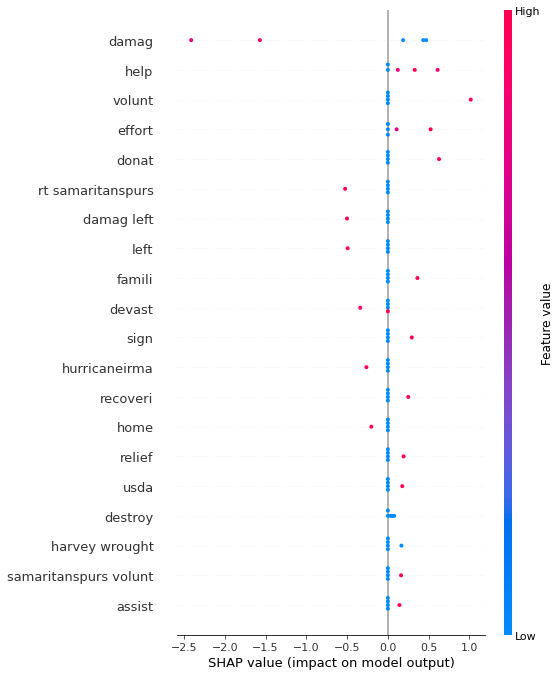

In [16]:
# SVM example

X_train, X_test, y_train, y_test = train_test_split(df['pre_processed'], df['class_label_num'], random_state=42, test_size=0.20, shuffle=True)

tfidf_vec = TfidfVectorizer(ngram_range=(1,2), lowercase=True)
train_vc = tfidf_vec.fit_transform(X_train)
test_vc = tfidf_vec.transform(X_test)

svm_classifier = SVC(kernel='poly', degree=2, C=10)
svm_classifier.fit(train_vc, y_train)

X_train_sample = shap.sample(train_vc, 100)
X_test_sample = shap.sample(test_vc, 5)
explainer = shap.KernelExplainer(svc_classifier.predict, X_train_sample, l1_reg="rank(3)")
shap_vals = explainer.shap_values(X_test_sample)
colour_df = pd.DataFrame(X_test_sample.todense())
shap.summary_plot(shap_vals, colour_df, feature_names=tfidf_vec.get_feature_names())

In [18]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_vals[1,:], 
                colour_df.iloc[1,:], feature_names=tfidf_vec.get_feature_names())

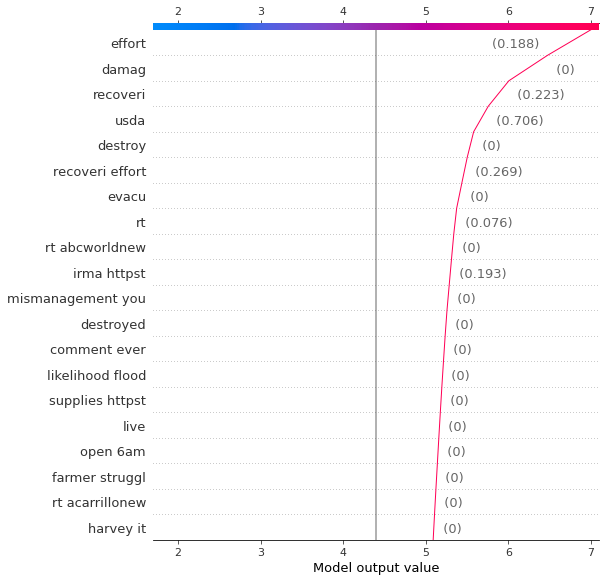

In [19]:
shap.decision_plot(explainer.expected_value, shap_vals[1,:], 
                colour_df.iloc[1,:], feature_names=tfidf_vec.get_feature_names())

In [ ]:
# still working - eli5 TextExplainer
# eli5.show_weights(clf, vec=tfidf_vec, top=20)

##### Step 9. Modify dataset based on LIME Analysis(add words as stopwords which contributes most in false-labeling)

In [ ]:
# still working
# Identify words to include as stopwords through LIME analysis
'''
def limestopwords(repeat=1, model_classifier=None, new_stop_words=None):
    # repeat iterations

    for i in range(repeat):
        if repeat == 1:
            df['pre_processed'] = df['text'].apply(lambda x: preprocess_text(x, flg_stemm=False, flg_lemm=False, lst_stopwords=None))
        if repeat > 1:
            df['pre_processed'] = df['pre_processed'].apply(lambda x: preprocess_text(x, flg_stemm=False, flg_lemm=False, lst_stopwords=new_stop_words))
    
    # split dataset, vectorize, and fit to classifier
        X_train, X_test, y_train, y_test = train_test_split(df['pre_processed'], df['class_label'], random_state=42, test_size=0.20, shuffle=True)

        train_vc = tfidf_vec.fit_transform(X_train)
        test_vc = tfidf_vec.transform(X_test)

        model_classifier.fit(train_vc, y_train)

        pred = model_classifier.predict(test_vc)

        test_set = pd.DataFrame(X_test)
        test_set['pred_label'] = pred
        test_set['label'] = y_test

    # sample wrongly predicted texts for each label
        test_set_w = test_set[test_set['pred_label'] != test_set['label']]
        #test_set_0 = test_set_w[test_set_w['pred_label'] == 0]
        #test_set_1 = test_set_w[test_set_w['pred_label'] == 1]
        test_set_0_rand = test_set_0.sample(n=500)
        test_set_1_rand = test_set_1.sample(n=500)

        model = model_classifier.fit(train_vc, y_train)
        c = make_pipeline(tfidf_vec, model)
        class_names = list(df['class_label'].unique())

    # create list of categories of words through LIME : True-positive, True-negative, False-positive, False-negative

        explainer = LimeTextExplainer(class_names=class_names)
        
        correct_list_0 = collections.defaultdict(list)
        wrong_list_0 = collections.defaultdict(list)

        correct_list_1 = collections.defaultdict(list)
        wrong_list_1 = collections.defaultdict(list)
        
        correct_word_0 = []
        correct_word_1 = []

        wrong_word_0 = []
        wrong_word_1 = []
        
        for i in test_set_0_rand.index:
            exp = explainer.explain_instance(test_set_0_rand['pre_processed'][i], c.predict_proba, num_features = 10)
            for n in range(len(exp.as_list())):
                if exp.as_list()[n][1] > 0.2:
                    word = exp.as_list()[n][0]
                    val = exp.as_list()[n][1]
                    wrong_word_0.append(word)
                    wrong_list_0[word].append(val)
                if exp.as_list()[n][1] < -0.2:
                    word = exp.as_list()[n][0]
                    val = exp.as_list()[n][1]
                    correct_word_0.append(word)
                    correct_list_0[word].append(val)

        for i in test_set_1_rand.index:
            exp = explainer.explain_instance(test_set_1_rand['pre_processed'][i], c.predict_proba, num_features = 10)
            for n in range(len(exp.as_list())):
                if exp.as_list()[n][1] > 0.2:
                    word = exp.as_list()[n][0]
                    val = exp.as_list()[n][1]
                    correct_word_1.append(word)
                    correct_list_1[word].append(val)
                if exp.as_list()[n][1] < -0.2:
                    word = exp.as_list()[n][0]
                    val = exp.as_list()[n][1]
                    wrong_word_1.append(word)
                    wrong_list_1[word].append(val)
          

        # Sort each category by highest or lowest depending on +/-
        # Use frequency of appearance or prediction probability as a decision making threshold
        wrong_list_0_comm = collections.OrderedDict(sorted(wrong_list_0.items(), key=lambda item: len(item[1]), reverse=True))
        wrong_list_0_highprob = collections.OrderedDict(sorted(wrong_list_0.items(), key=lambda item: np.mean(item[1])))
        correct_list_0_comm = collections.OrderedDict(sorted(correct_list_0.items(), key=lambda item: len(item[1])))
        correct_list_0_highprob = collections.OrderedDict(sorted(correct_list_0.items(), key=lambda item: np.mean(item[1]), reverse=True))

        wrong_list_1_comm = collections.OrderedDict(sorted(wrong_list_1.items(), key=lambda item: len(item[1]), reverse=True))
        wrong_list_1_highprob = collections.OrderedDict(sorted(wrong_list_1.items(), key=lambda item: np.mean(item[1])))
        correct_list_1_comm = collections.OrderedDict(sorted(correct_list_1.items(), key=lambda item: len(item[1])))
        correct_list_1_highprob = collections.OrderedDict(sorted(correct_list_1.items(), key=lambda item: np.mean(item[1]), reverse=True))

        # select fifty highest sorted words : predict probability
        correct_list_0_highest_score = list(correct_list_0_highprob.keys())[:30]
        correct_list_1_highest_score = list(correct_list_1_highprob.keys())[:30]

        wrong_list_0_highest_score = list(wrong_list_0_highprob.keys())[:30]
        wrong_list_1_highest_score = list(wrong_list_1_highprob.keys())[:30]

        correct_word_0_sort = dict((x,correct_word_0.count(x)) for x in set(correct_word_0))
        correct_word_0_sort = sorted(correct_word_0_sort.items(), key=lambda x: x[1], reverse=True)

        correct_word_1_sort = dict((x,correct_word_1.count(x)) for x in set(correct_word_1))
        correct_word_1_sort = sorted(correct_word_1_sort.items(), key=lambda x: x[1], reverse=True)

        wrong_word_0_sort = dict((x,wrong_word_0.count(x)) for x in set(wrong_word_0))
        wrong_word_0_sort = sorted(wrong_word_0_sort.items(), key=lambda x: x[1], reverse=True)

        wrong_word_1_sort = dict((x,wrong_word_1.count(x)) for x in set(wrong_word_1))
        wrong_word_1_sort = sorted(wrong_word_1_sort.items(), key=lambda x: x[1], reverse=True)
    
        # select fifty highest sorted words : appearance
        correct_0_highest_appearance = [i[0] for i in correct_word_0_sort[:30]]
        correct_1_highest_appearance = [i[0] for i in correct_word_1_sort[:30]]
        wrong_0_highest_appearance = [i[0] for i in wrong_word_0_sort[:30]]
        wrong_1_highest_appearance = [i[0] for i in wrong_word_1_sort[:30]]

        # within the false labeled texts, distinguish between correctly and falsely predicting words
        correct_words = correct_list_0_highest_score + correct_list_1_highest_score
        wrong_words = wrong_list_0_highest_score + wrong_list_1_highest_score

        # discard corretly predicting words from wrongly predicting words and create new list of stopwords
        new_stop_words = [elem for elem in wrong_words if elem not in correct_words]
        
        return new_stop_words

new_stop_words = limestopwords(repeat=1, model_classifier=lr_classifier)
'''

##### Step 8. Adjust dataset based on LIME Analysis and renew results

In [ ]:
# still working
# re-preprocess dataset based on LIME analysis and make new prediction
'''
df['new_processed'] = df['pre_processed'].apply(lambda x: preprocess_text(x, flg_stemm=False, flg_lemm=False, lst_stopwords=new_stop_words))
#test_df['new_processed'] = test_df['pre_processed'].apply(lambda x: preprocess_text(x, flg_stemm=False, flg_lemm=False, lst_stopwords=new_stop_words))

X_train, X_test, y_train, y_test = train_test_split(df['new_processed'], df['class_label'], random_state=42, test_size=0.10, shuffle=True)

train_vc = tfidf_vec.fit_transform(X_train)
test_vc = tfidf_vec.transform(X_test)

#fit classifiers and make predictions
models = {"Logistic Regression": LogisticRegression(C=100, multi_class='multinomial', penalty='l2'),
          "MultinomialNB": MultinomialNB(fit_prior=False, alpha=5),
          "RandomForest": RandomForestClassifier(n_estimators=200, max_depth = None),
          "SVC": SVC(kernel='poly', degree=2, C=10),
          "MLP": MLPClassifier(hidden_layer_sizes=200, activation='tanh', solver='adam', alpha=0.001)
          }
          
for name, model in models.items(): 
    model.fit(train_vc, y_train) 
    pred=model.predict(test_vc)
    test_score = model.score(test_vc, y_test)
    met = metrics.classification_report(y_test, pred, target_names=target_names, output_dict=True)
    confusion_matrix=metrics.confusion_matrix(y_test, pred)
    print("{} Test Set Accuracy: {}".format(name, test_score))
    print("{} report: {}".format(name, met))
    print("{} Confusion_matrix: {}".format(name, confusion_matrix))
    print("_"*50)
    '''